# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
#from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
!pip install user_agents

In [3]:
from user_agents import parse

In [4]:
import os
#print(os.environ['HADOOP_HOME'])
#print(os.environ['JAVA_HOME'])
print(os.environ['PATH'])
print(os.environ['SPARK_HOME'])

/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/spark/bin
/usr/local/spark


In [5]:
import sys
# python version
sys.version

'3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]'

In [6]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify Project') \
    .config('spark.jars.packages', 'com.microsoft.azure:synapseml_2.12:1.0.1') \
    .getOrCreate()

In [7]:
import synapse.ml
from synapse.ml.lightgbm import LightGBMClassifier

In [8]:
print('SynapseML version: {}'.format(synapse.ml.lightgbm.__version__))

SynapseML version: 1.0.1


In [9]:
spark.version

'3.5.0'

In [10]:
!pip install findspark

In [11]:
import findspark
findspark.init() 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [12]:
df = spark.read.json('data/mini_sparkify_event_data.json')

In [13]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
df.count()

286500

In [15]:
def clean_data(df):
    '''
    INPUT
    df - dataframe

    OUTPUT
    df - dataframe

    '''
    # Drop rows with missing userId and sessionId values
    df = df.dropna(how='any', subset=['userId', "sessionId"])
    df = df.filter(df['userId'] != '')

    return df

In [16]:
df = clean_data(df)

In [17]:
df.count()

278154

In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [19]:
df_pandas = df.toPandas()

In [20]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [21]:
df_pandas.to_csv('data/df.csv')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [22]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [23]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



In [24]:
df.select(['userId', 'page']).where(df.page == 'Cancellation Confirmation').count()

52

In [25]:
df.select(['userId', 'page']).where(df.page == 'Cancellation Confirmation').show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



#### Churn

In [26]:
def create_target_label(df):
    '''
    INPUT
    df - pandas dataframe

    OUTPUT
    df - pandas dataframe

    This function create target label:
    '''

    churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    df = df.withColumn('churn', churn_event('page'))

    return df

In [27]:
df = create_target_label(df)

In [28]:
df.count()

278154

#### Level

In [29]:
df_pandas_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count().toPandas()

In [30]:
df_pandas_level.sort_values('count', ascending = False)

,level,churn,count
1,free,0,195
0,paid,0,165
2,paid,1,31
3,free,1,21


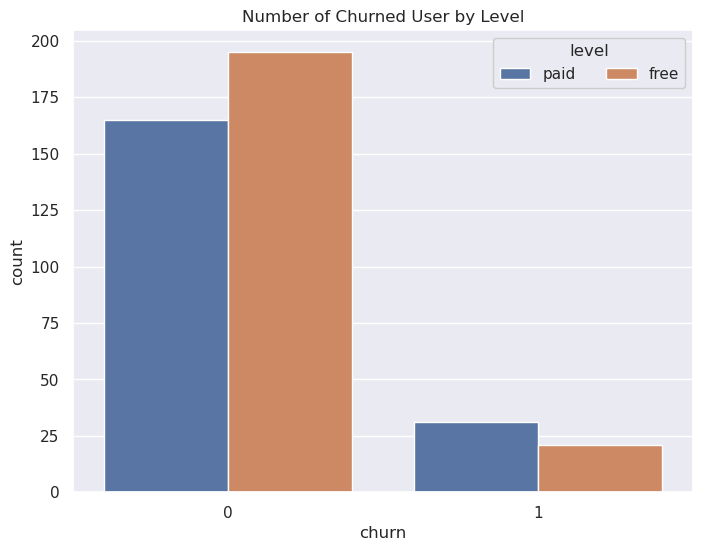

In [31]:
# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_pandas_level, x='churn', y='count', hue='level')
ax.legend(loc=1, ncol=2, framealpha=1, title='level')
plt.title('Number of Churned User by Level');

#### Gender

In [32]:
df_pandas_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count().toPandas()

In [33]:
df_pandas_gender.head()

,gender,churn,count
0,M,1,32
1,F,0,104
2,F,1,20
3,M,0,121


In [34]:
df_pandas_gender.sort_values('count', ascending = False)

,gender,churn,count
3,M,0,121
1,F,0,104
0,M,1,32
2,F,1,20


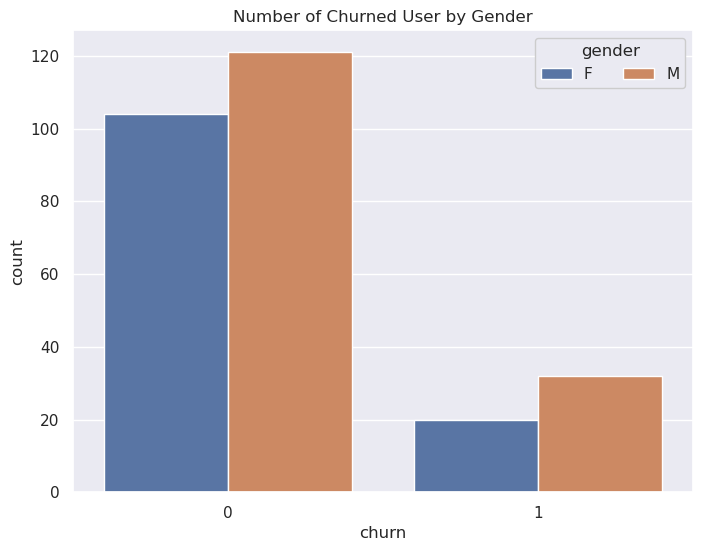

In [35]:
# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_pandas_gender, x='churn', y='count', hue='gender')
ax.legend(loc=1, ncol=2, framealpha=1, title='gender')
plt.title('Number of Churned User by Gender');

In [36]:
df.groupby(df.churn).agg(countDistinct('userId')).show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   225|
+-----+----------------------+



In [37]:
# calculate churn rate
print('{0:.0%} of users have churned'.format(52/225))

23% of users have churned


In [38]:
df_pandas = df.toPandas()

In [39]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [40]:
df_pandas.describe()

,itemInSession,length,registration,sessionId,status,ts,churn
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.000187
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.013672
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000


In [41]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [42]:
df_page = df_page.toPandas()

In [43]:
df_display = df.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [44]:
df_display = df_display.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [45]:
df_pandas = df_display.toPandas()

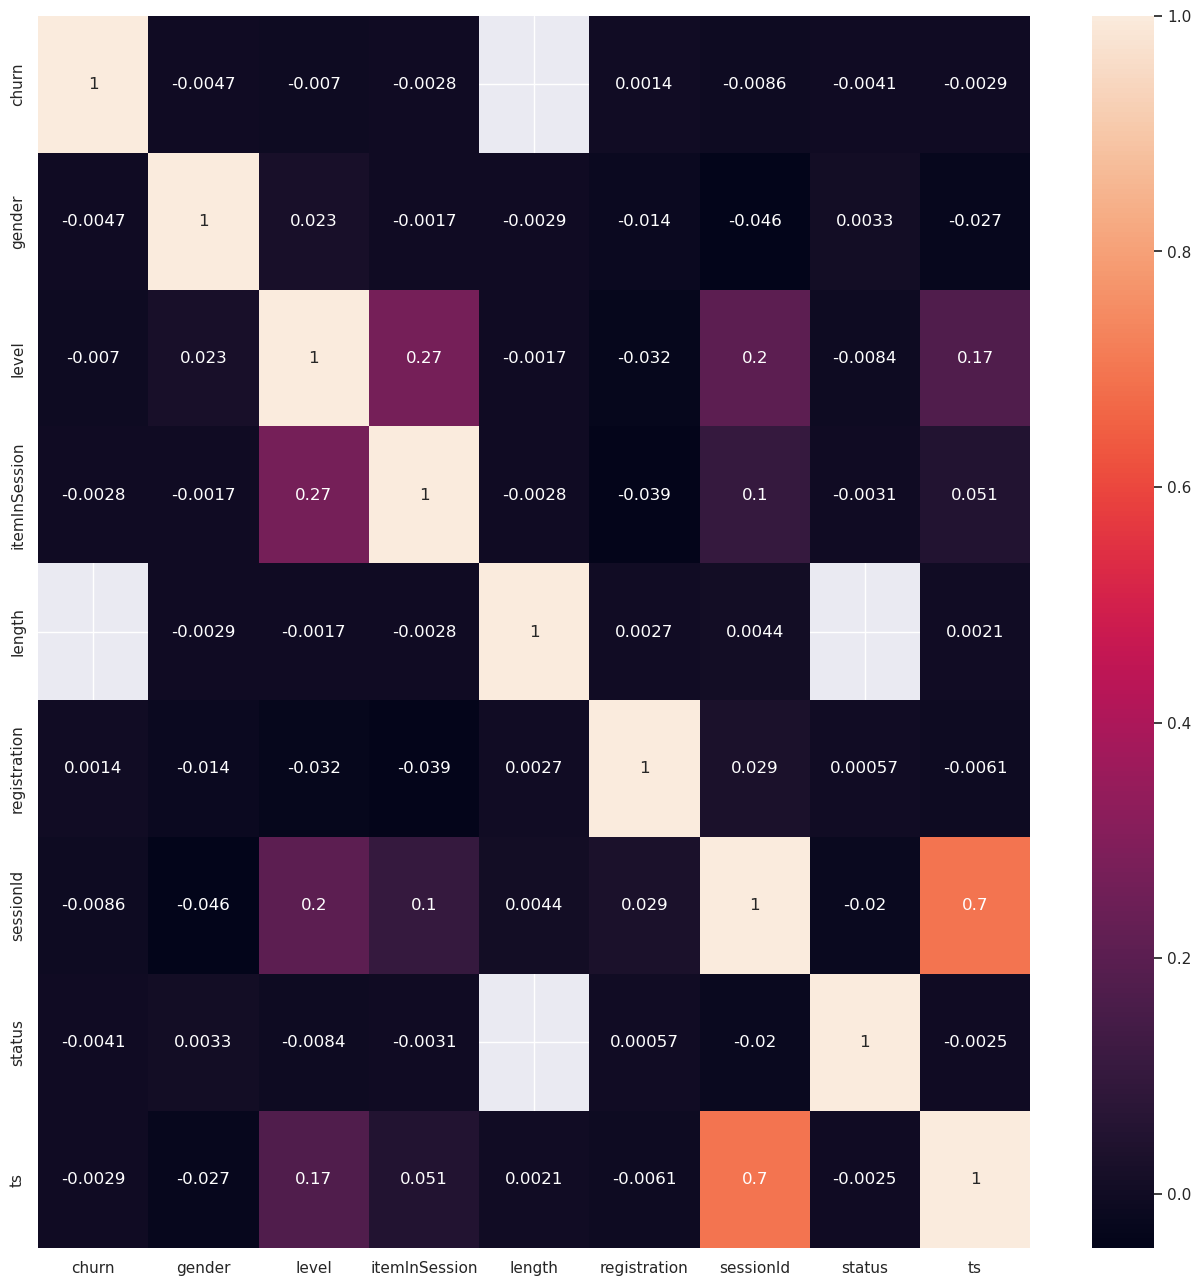

In [46]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_pandas[[
    'churn',
    'gender',
    'level',
    'itemInSession',
    'length',
    'registration',
    'sessionId',
    'status',
    'ts']].corr(), annot=True)
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [47]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)



In [48]:
categorical_features = [
    'gender',
    'level'
]
target_label = ['churn']
drop_features = [
    'artist',
    'auth',
    'firstName',
    'itemInSession',
    'lastName',
    'length',
    'location',
    'method',
    'page',
    'registration',
    'sessionId',
    'song',
    'status',
    'ts',
    'userAgent',
    'userId'
]

#### Gender

In [49]:
df_gender_to_join = df.select(['userId', 'gender']).dropDuplicates()

In [50]:
df_gender_to_join = df_gender_to_join.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [51]:
df_gender_to_join.count()

225

In [52]:
df_gender_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = false)



#### Level

In [53]:
df_level_to_join = df.select(['userId', 'level']).dropDuplicates()

In [54]:
df_level_to_join = df_level_to_join.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [55]:
df_level_to_join = df_level_to_join.select(['userId', 'level']).dropDuplicates().groupby('userId').sum()

In [56]:
df_level_to_join = df_level_to_join.withColumnRenamed('sum(level)', 'level')

In [57]:
df_level_to_join.count()

225

In [58]:
df_level_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- level: long (nullable = true)



#### Days

In [59]:
df_day_to_join = df.select(['userId', 'ts', 'registration', "churn"]).dropDuplicates()

In [60]:
df_day_to_join= df_day_to_join.groupBy('userId', 'registration').agg(max('ts').alias('max_ts'))

In [61]:
df_day_to_join.count()

225

In [62]:
df_day_to_join = df_day_to_join.withColumn('delta_days', (df_day_to_join['max_ts']) - (df_day_to_join['registration']))

In [63]:
df_day_to_join = df_day_to_join.withColumn('days', (df_day_to_join['delta_days']/1000/3600/24))

In [64]:
df_day_to_join = df_day_to_join.drop('registration', 'ts', 'max_ts', 'delta_days', "churn")

In [65]:
df_day_to_join.count()

225

In [66]:
df_day_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- days: double (nullable = true)



#### Thumb down

In [67]:
df_thumddown_to_join = df.select(['userId', 'page'])

In [68]:
thumddown_event = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

In [69]:
df_thumddown_to_join = df_thumddown_to_join.withColumn('Thumbs Down', thumddown_event('page'))

In [70]:
df_thumddown_to_join = df_thumddown_to_join.groupby('userId').sum('Thumbs Down')

In [71]:
df_thumddown_to_join = df_thumddown_to_join.withColumnRenamed('sum(Thumbs Down)', 'thumbs_down')

In [72]:
df_thumddown_to_join.count()

225

In [73]:
df_thumddown_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- thumbs_down: long (nullable = true)



#### Thumb up

In [74]:
df_thumdup_to_join = df.select(['userId', 'page'])

In [75]:
thumdup_event = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())

In [76]:
df_thumdup_to_join = df_thumdup_to_join.withColumn('Thumbs Up', thumdup_event("page"))

In [77]:
df_thumdup_to_join = df_thumdup_to_join.groupby('userId').sum('Thumbs Up')

In [78]:
df_thumdup_to_join = df_thumdup_to_join.withColumnRenamed('sum(Thumbs Up)', 'thumbs_up')

In [79]:
df_thumdup_to_join.count()

225

In [80]:
df_thumdup_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- thumbs_up: long (nullable = true)



#### Friends added

In [81]:
df_addfriend_to_join = df.select(['userId', 'page'])

In [82]:
addfriend_event = udf(lambda x: 1 if x == 'Add Friend' else 0, IntegerType())

In [83]:
df_addfriend_to_join = df_addfriend_to_join.withColumn('Add Friend', addfriend_event('page'))

In [84]:
df_addfriend_to_join = df_addfriend_to_join.groupby('userId').sum('Add Friend')

In [85]:
df_addfriend_to_join = df_addfriend_to_join.withColumnRenamed('sum(Add Friend)', 'add_friend')

In [86]:
df_addfriend_to_join.count()

225

In [87]:
df_addfriend_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- add_friend: long (nullable = true)



#### Playlist added

In [88]:
df_addplaylist_to_join = df.select(['userId', 'page'])

In [89]:
addplaylist_event = udf(lambda x: 1 if x == 'Add to Playlist' else 0, IntegerType())

In [90]:
df_addplaylist_to_join = df_addplaylist_to_join.withColumn('Add to Playlist', addplaylist_event('page'))

In [91]:
df_addplaylist_to_join = df_addplaylist_to_join.groupby('userId').sum('Add to Playlist')

In [92]:
df_addplaylist_to_join = df_addplaylist_to_join.withColumnRenamed('sum(Add to Playlist)', 'add_playlist')

In [93]:
df_addplaylist_to_join.count()

225

In [94]:
df_addplaylist_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- add_playlist: long (nullable = true)



#### Rollads

In [95]:
df_rollads_to_join = df.select(['userId', 'page'])

In [96]:
rollads_event = udf(lambda x: 1 if x == 'Roll Advert' else 0, IntegerType())

In [97]:
df_rollads_to_join = df_rollads_to_join.withColumn('Roll Advert', rollads_event('page'))

In [98]:
df_rollads_to_join = df_rollads_to_join.groupby('userId').sum('Roll Advert')

In [99]:
df_rollads_to_join = df_rollads_to_join.withColumnRenamed('sum(Roll Advert)', 'roll_ad')

In [100]:
df_rollads_to_join.count()

225

In [101]:
df_rollads_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- roll_ad: long (nullable = true)



#### Downgrade

In [102]:
df_downgrade_to_join = df.select(['userId', 'page'])

In [103]:
downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [104]:
df_downgrade_to_join = df_downgrade_to_join.withColumn('Submit Downgrade', downgrade_event('page'))

In [105]:
df_downgrade_to_join = df_downgrade_to_join.groupby('userId').sum('Submit Downgrade')

In [106]:
df_downgrade_to_join = df_downgrade_to_join.withColumnRenamed('sum(Submit Downgrade)', 'downgrade')

In [107]:
df_downgrade_to_join.count()

225

In [108]:
df_downgrade_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- downgrade: long (nullable = true)



#### Upgrade

In [109]:
df_upgrade_to_join = df.select(['userId', 'page'])

In [110]:
upgrade_event = udf(lambda x: 1 if x == 'Submit Upgrade' else 0, IntegerType())

In [111]:
df_upgrade_to_join = df_upgrade_to_join.withColumn('Submit Upgrade', upgrade_event('page'))

In [112]:
df_upgrade_to_join = df_upgrade_to_join.groupby('userId').sum('Submit Upgrade')

In [113]:
df_upgrade_to_join = df_upgrade_to_join.withColumnRenamed('sum(Submit Upgrade)', 'upgrade')

In [114]:
df_upgrade_to_join.count()

225

In [115]:
df_upgrade_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- upgrade: long (nullable = true)



#### Average number of Song

In [116]:
df_avgsong_to_join = df.filter(df.page == 'NextSong').groupBy('userId','sessionId').count()

In [117]:
df_avgsong_to_join = df_avgsong_to_join.groupby('userId').agg({'count':'avg'})

In [118]:
df_avgsong_to_join = df_avgsong_to_join.withColumnRenamed('avg(count)', 'avg_song')

In [119]:
df_avgsong_to_join.count()

225

In [120]:
df_avgsong_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- avg_song: double (nullable = true)



#### Number of Artist

In [121]:
df_number_airtist_to_join = df.select('userId', 'artist').dropDuplicates().groupby('userId').count()

In [122]:
df_number_airtist_to_join = df_number_airtist_to_join.withColumnRenamed('count', 'number_artist')

In [123]:
df_number_airtist_to_join.count()

225

In [124]:
df_number_airtist_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- number_artist: long (nullable = false)



#### creat target label

In [125]:
df_label_to_join = df.select('userId', 'churn').dropDuplicates().groupby('userId').sum()

In [126]:
df_label_to_join = df_label_to_join.withColumnRenamed('sum(churn)', 'label')

In [127]:
df_label_to_join.count()

225

In [128]:
df_label_to_join.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)



#### Create Features Dataset

In [129]:
df_feature = df_gender_to_join.join(df_level_to_join, ['userId']).join(df_day_to_join, ['userId']).join(df_thumddown_to_join, ['userId']).join(df_thumdup_to_join, ['userId'])
df_feature = df_feature.join(df_addfriend_to_join, ['userId']).join(df_addplaylist_to_join, ['userId']).join(df_rollads_to_join, ['userId']).join(df_avgsong_to_join, ['userId'])
df_feature = df_feature.join(df_number_airtist_to_join, ['userId']).join(df_downgrade_to_join, ['userId']).join(df_upgrade_to_join, ['userId']).join(df_label_to_join, ['userId'])

In [130]:
df_feature.toPandas().to_csv('data/df_feature.csv')

In [131]:
df_feature = df_feature.drop('userId')

In [132]:
df_feature.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: long (nullable = true)
 |-- days: double (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- add_playlist: long (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- avg_song: double (nullable = true)
 |-- number_artist: long (nullable = false)
 |-- downgrade: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- label: long (nullable = true)



In [133]:
for feature in df_feature.columns:
    df_feature = df_feature.withColumn(feature, df_feature[feature].cast('float'))

In [134]:
df_feature.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = true)
 |-- days: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- add_playlist: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- avg_song: float (nullable = true)
 |-- number_artist: float (nullable = false)
 |-- downgrade: float (nullable = true)
 |-- upgrade: float (nullable = true)
 |-- label: float (nullable = true)



In [135]:
df_feature.count()

225

In [136]:
df_feature.columns

['gender',
 'level',
 'days',
 'thumbs_down',
 'thumbs_up',
 'add_friend',
 'add_playlist',
 'roll_ad',
 'avg_song',
 'number_artist',
 'downgrade',
 'upgrade',
 'label']

In [137]:
df_pandas_feature = df_feature.toPandas()

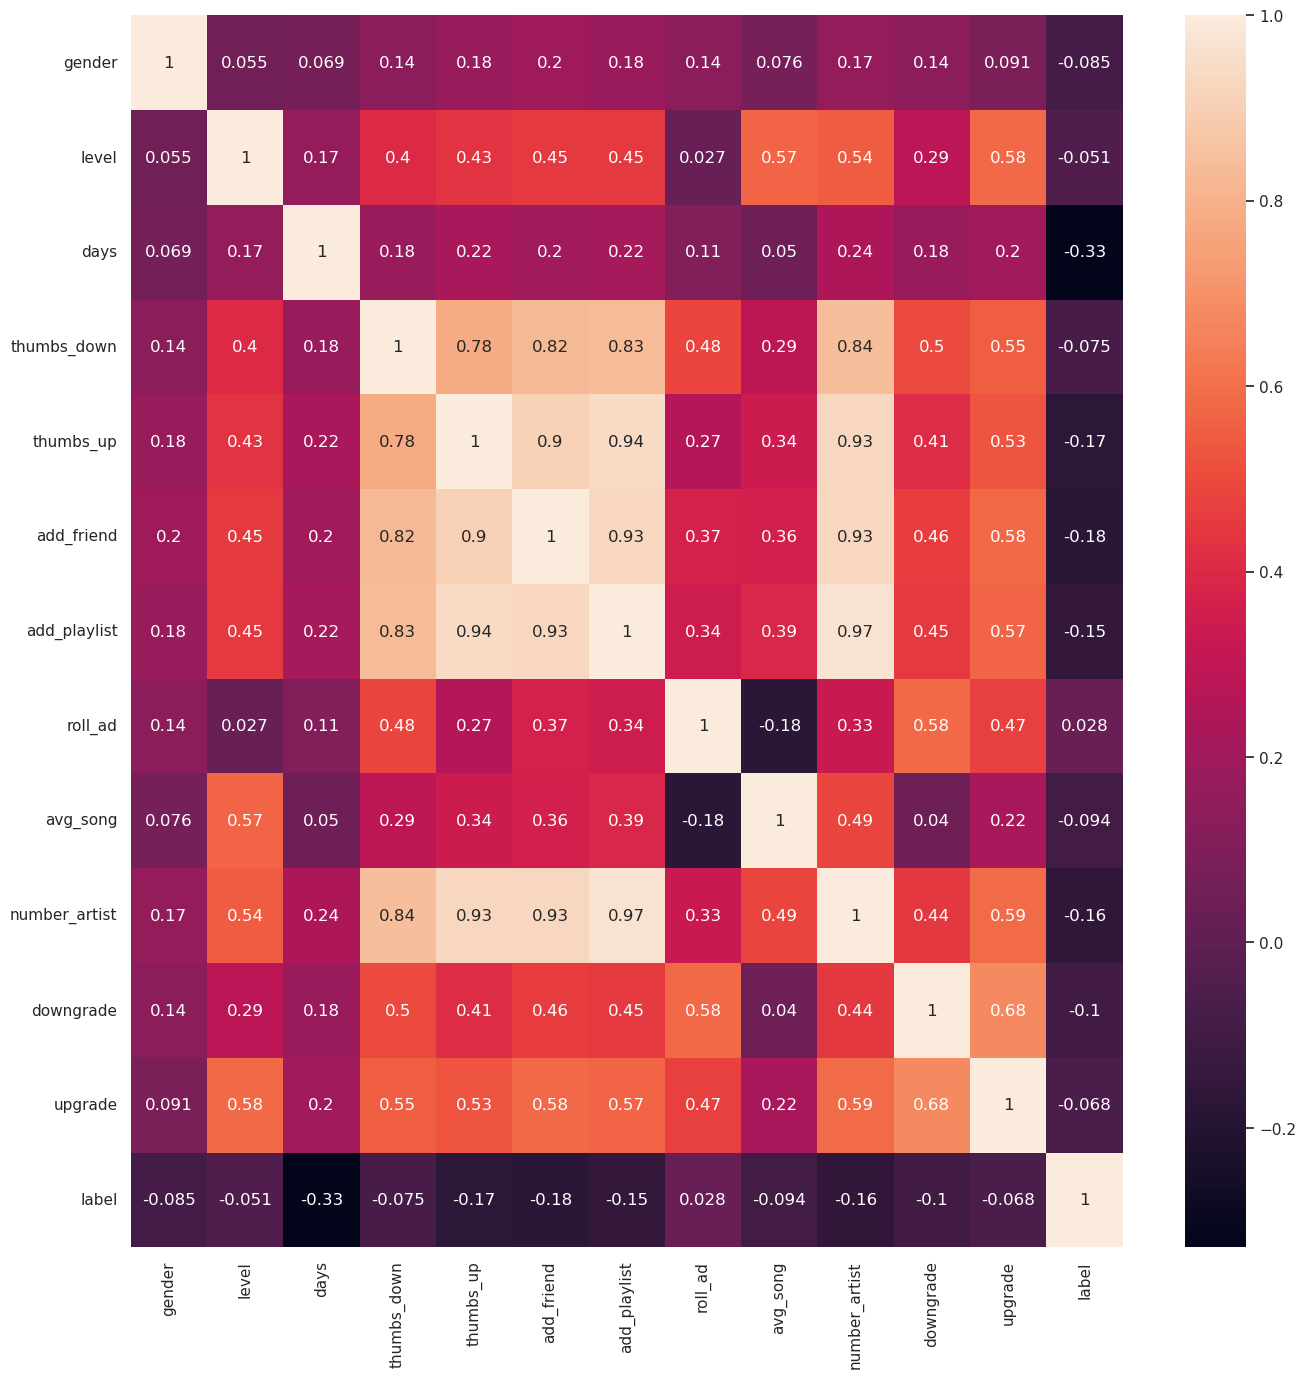

In [138]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_pandas_feature[df_feature.columns].corr(), annot=True)
plt.show()

#### Preprocessing

In [139]:
feature_list = list(['gender', 'level', 'days', 'thumbs_down', 'thumbs_up', 'add_friend', 'add_playlist', 'roll_ad', 'avg_song', 'number_artist', 'downgrade', 'upgrade'])
#feature_list = list(["gender", "level", "days", 'avg_song', 'roll_ad'])

In [140]:
assembler = VectorAssembler(inputCols=feature_list, outputCol='vec_features')

In [141]:
df_assembler_feature = assembler.transform(df_feature)

In [142]:
scaler = StandardScaler(inputCol='vec_features', outputCol='features', withStd=True)

In [143]:
scaler_model = scaler.fit(df_assembler_feature)

In [144]:
df_assembler_scaler_feature = scaler_model.transform(df_assembler_feature)

In [145]:
df_preprocessing = df_assembler_scaler_feature

In [146]:
df_preprocessing.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = true)
 |-- days: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- add_playlist: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- avg_song: float (nullable = true)
 |-- number_artist: float (nullable = false)
 |-- downgrade: float (nullable = true)
 |-- upgrade: float (nullable = true)
 |-- label: float (nullable = true)
 |-- vec_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [147]:
df_preprocessing.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [148]:
df_preprocessing.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = true)
 |-- days: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- add_playlist: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- avg_song: float (nullable = true)
 |-- number_artist: float (nullable = false)
 |-- downgrade: float (nullable = true)
 |-- upgrade: float (nullable = true)
 |-- label: float (nullable = true)
 |-- vec_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [149]:
df_preprocessing.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



### Train, Test, Validation Split(60%, 20%, 20%)

In [150]:
train, test, valid = df_preprocessing.randomSplit([0.6, 0.2, 0.2], seed = 2023)

In [151]:
print('Training Dataset:' + str(train.count()))
print('Test Dataset:' + str(test.count()))
print('Validation Dataset:' + str(valid.count()))

Training Dataset:121
Test Dataset:64
Validation Dataset:40


### Training, Evaluating

In [152]:
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=2023)
nb = NaiveBayes(featuresCol='features', labelCol='label')
lsvc = LinearSVC(featuresCol='features', labelCol='label')
gbt = GBTClassifier(featuresCol='features', labelCol='label')
lightgbm = LightGBMClassifier(objective='binary', featuresCol='features', labelCol='label', seed=2023)

In [153]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
binaryEvaluator = BinaryClassificationEvaluator()

In [154]:
list_model = [lr, rf, nb, lsvc, gbt, lightgbm]

In [155]:
list_comparison_table = []
list_comparison_table.append(['model', 'f1', 'accuracy'])
for model in list_model:
    model = model.fit(train)
    predictions = model.transform(test)
    model_name = model.__class__.__name__
    result_list = []
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    accuracy = binaryEvaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
    result_list.append(model_name)
    result_list.append("{:.2f}".format(f1))
    result_list.append("{:.2f}".format(accuracy))
    list_comparison_table.append(result_list)
    print('F1 for {0} : {1}'.format(model_name, f1))
    print('Accuracy for {0} : {1}'.format(model_name, accuracy))

F1 for LogisticRegressionModel : 0.7442176870748299
Accuracy for LogisticRegressionModel : 0.7291666666666665
F1 for RandomForestClassificationModel : 0.830316742081448
Accuracy for RandomForestClassificationModel : 0.7591145833333335
F1 for NaiveBayesModel : 0.659343312409464
Accuracy for NaiveBayesModel : 0.65234375
F1 for LinearSVCModel : 0.7963800904977375
Accuracy for LinearSVCModel : 0.720052083333333
F1 for GBTClassificationModel : 0.6366810774858664
Accuracy for GBTClassificationModel : 0.48502604166666674
F1 for LightGBMClassificationModel : 0.7546933667083855
Accuracy for LightGBMClassificationModel : 0.7239583333333331


In [156]:
from IPython.display import HTML, display

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

In [157]:
display_table(list_comparison_table)

model,f1,accuracy
LogisticRegressionModel,0.74,0.73
RandomForestClassificationModel,0.83,0.76
NaiveBayesModel,0.66,0.65
LinearSVCModel,0.80,0.72
GBTClassificationModel,0.64,0.49
LightGBMClassificationModel,0.75,0.72


In [158]:
print(lightgbm.explainParams())

baggingFraction: Bagging fraction (default: 1.0)
baggingFreq: Bagging frequency (default: 0)
baggingSeed: Bagging seed (default: 3)
binSampleCount: Number of samples considered at computing histogram bins (default: 200000)
boostFromAverage: Adjusts initial score to the mean of labels for faster convergence (default: True)
boostingType: Default gbdt = traditional Gradient Boosting Decision Tree. Options are: gbdt, gbrt, rf (Random Forest), random_forest, dart (Dropouts meet Multiple Additive Regression Trees), goss (Gradient-based One-Side Sampling).  (default: gbdt)
catSmooth: this can reduce the effect of noises in categorical features, especially for categories with few data (default: 10.0)
categoricalSlotIndexes: List of categorical column indexes, the slot index in the features column (default: [])
categoricalSlotNames: List of categorical column slot names, the slot name in the features column (default: [])
catl2: L2 regularization in categorical split (default: 10.0)
chunkSize: A

In [159]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

### Hyper Parameter Tuning 

## LightGBM Classifier

In [160]:
paramGrid = ParamGridBuilder() \
    .addGrid(lightgbm.numLeaves, [32, 64, 128]) \
    .addGrid(lightgbm.maxDepth, [5, 10, 15]) \
    .build()

In [161]:
crossval = CrossValidator(estimator=lightgbm,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=5)

In [162]:
cvModel = crossval.fit(train)

In [163]:
cvModel.avgMetrics

[0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696,
 0.7537858994012696]

In [164]:
best_model = cvModel.bestModel

In [165]:
#print ("Best Param (numLeaves): ", best_model.getJavaObj().getNumLeaves())
#print ("Best Param (MaxDepth): ", best_model.getJavaObj().getMaxDepth())

In [166]:
predictions = best_model.transform(valid)

In [167]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: 'f1'}))

F1 for our best model is: 0.8316864295125164


### Feature Importance

In [168]:
importances = best_model.getFeatureImportances()

In [169]:
importance = pd.DataFrame(importances, index=feature_list, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)

In [170]:
x_values = list(range(len(importances)))

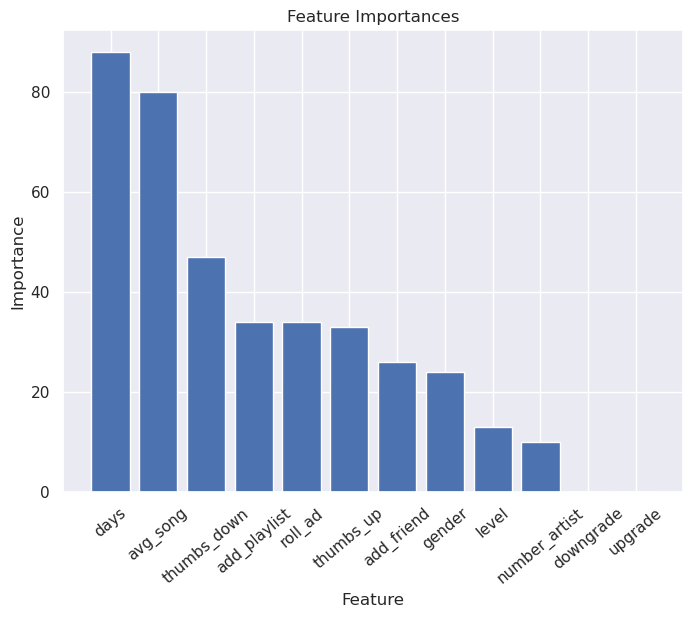

In [171]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importance['importance'], orientation='vertical')
plt.xticks(x_values, importance.index, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

### Confusion matrix for the best model

In [172]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [173]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90        35
         1.0       0.33      0.40      0.36         5

    accuracy                           0.82        40
   macro avg       0.62      0.64      0.63        40
weighted avg       0.84      0.82      0.83        40



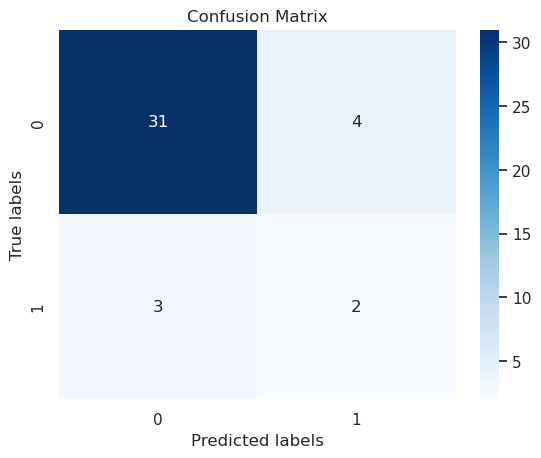

In [174]:
ax = plt.subplot()
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, ax=ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

## Random Forest Classifier

In [175]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()

In [176]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=5)

In [177]:
cvModel = crossval.fit(train)

In [178]:
cvModel.avgMetrics

[0.763581217494261,
 0.7709588398718834,
 0.7709588398718834,
 0.7650414198391953,
 0.7679100729252397,
 0.7679100729252397,
 0.7708879645987836,
 0.7745912380694989,
 0.7745912380694989]

In [179]:
best_model = cvModel.bestModel

In [180]:
print ('Best Param (NumTrees): ', best_model._java_obj.getNumTrees())
print ('Best Param (MaxDepth): ', best_model._java_obj.getMaxDepth())

Best Param (NumTrees):  100
Best Param (MaxDepth):  10


In [181]:
predictions = best_model.transform(valid)

In [182]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: 'f1'}))

F1 for our best model is: 0.8689358372456963


### Feature Importance

In [183]:
importances = best_model.featureImportances

In [184]:
importance = pd.DataFrame(importances.toArray(), index=feature_list, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)

In [185]:
x_values = list(range(len(importances)))

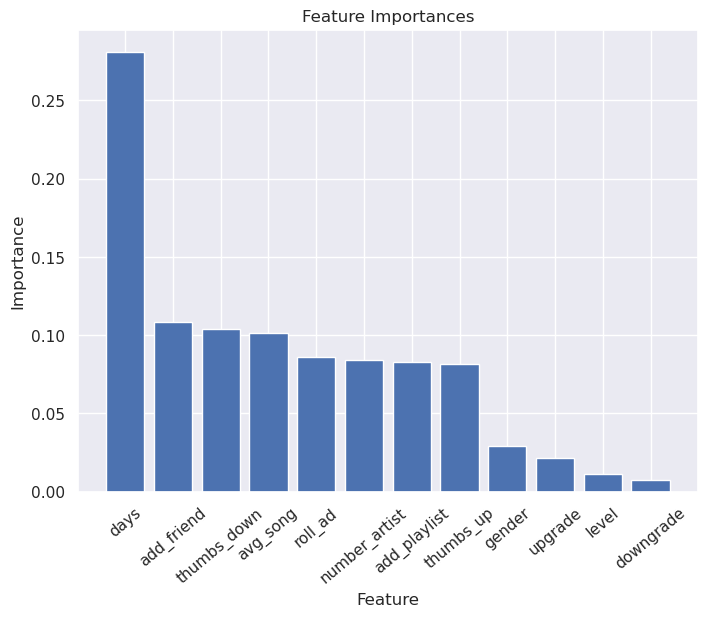

In [186]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importance['importance'], orientation='vertical')
plt.xticks(x_values, importance.index, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

In [187]:
### Confusion matrix for the best model

In [188]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [189]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93        35
         1.0       0.50      0.40      0.44         5

    accuracy                           0.88        40
   macro avg       0.71      0.67      0.69        40
weighted avg       0.86      0.88      0.87        40



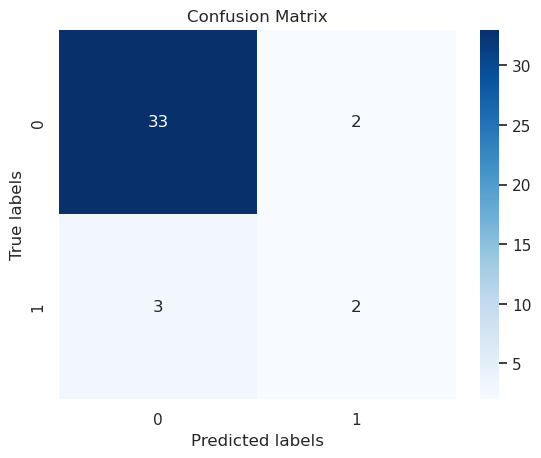

In [190]:
ax = plt.subplot()
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, ax=ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

### Build Pipeline

In [191]:
lightgbm_pipeline = Pipeline(stages=[assembler, scaler, lightgbm])

In [192]:
train, test, valid = df_feature.randomSplit([0.6, 0.2, 0.2], seed = 1996)

In [193]:
lightgbm_model = lightgbm_pipeline.fit(train)

In [194]:
lightgbm_preds = lightgbm_model.transform(test)

In [195]:
print('F1 for {} is:'.format('lightgbm'), evaluator.evaluate(lightgbm_preds, {evaluator.metricName: 'f1'}))

F1 for lightgbm is: 0.7698412698412699


In [196]:
lightgbm_preds = lightgbm_model.transform(valid)

In [197]:
print('F1 for {} is:'.format('lightgbm'), evaluator.evaluate(lightgbm_preds, {evaluator.metricName: 'f1'}))

F1 for lightgbm is: 0.7658402203856749


In [198]:
y_true = lightgbm_preds.select(['label']).collect()
y_pred = lightgbm_preds.select(['prediction']).collect()

In [199]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85        32
         1.0       0.60      0.50      0.55        12

    accuracy                           0.77        44
   macro avg       0.71      0.69      0.70        44
weighted avg       0.76      0.77      0.77        44



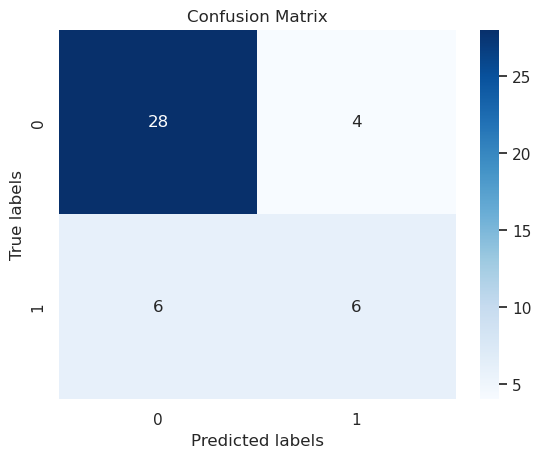

In [200]:
ax = plt.subplot()
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, ax=ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.